# Grounded Segement Anything

![gdgligen](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

**Why this project?**
- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks. 
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text. 
- The combination of the two models enable to **detect and segment everything** with text inputs!

# Prepare Environments

In [4]:
# ! python -m pip install -e segment_anything
# ! python -m pip install -e GroundingDINO
# ! pip install diffusers transformers accelerate scipy safetensors

Obtaining file:///home/liushilong/code/GroundingFolder/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


In [1]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [2]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [105]:
%load_ext autoreload
%autoreload 2

import argparse
import os
import copy
import sys
import torch
from GroundingDINO.groundingdino.util.inference import annotate

from GSAM import GSAM, GDINO, SAM
import gc


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load GSAM pipeline

In [402]:
del gsam

In [404]:
torch.cuda.empty_cache()
gc.collect()

0

In [351]:
gsam = GSAM(device="cuda" if torch.cuda.is_available() else "cpu")

GSAM initialized
final text_encoder_type: bert-base-uncased


A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Model loaded from /home/user1/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


# Load demo image

In [352]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)

In [381]:
# local_image_path = 'assets/inpaint_demo.jpg'
local_image_path = '../data/bag_arena_simple/sample0/rgb/test_100.jpg'

# Run Grounding DINO for detection

In [382]:
labels = ["chair", "picture", "ceiling light", 'lamp', 'ground', 'ceiling', 'robot', 'table', 'monitor', 'wall', 'floor', 'person', 'laptop', 'keyboard', 'mouse', 'screen', 'computer', 'tv', 'monitor', 'display', 'desk', 'window']

image_source, image = gsam.load_image(local_image_path)

boxes, scores, phrases, text_embeddings = gsam.groundingdino_model.predict_captions(image, labels)


In [383]:
# empty ids
empty_ids = [i for i, box in enumerate(boxes) if len(box) == 0]

# filter boxes
boxes = [box for i, box in enumerate(boxes) if i not in empty_ids]
scores = [score for i, score in enumerate(scores) if i not in empty_ids]
not_found_phrases = [not_found_phrase for i, not_found_phrase in enumerate(labels) if i in empty_ids]
phrases = [phrase for i, phrase in enumerate(phrases) if i not in empty_ids]
text_embeddings = [text_embedding for i, text_embedding in enumerate(text_embeddings) if i not in empty_ids]

In [384]:
annotated_frame = image_source
for box, logit, phrase in zip(boxes, scores, phrases):
    annotated_frame = annotate(image_source=annotated_frame, boxes=box, logits=logit, phrases=phrase)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB

In [385]:
not_found_phrases

['picture',
 'ceiling light',
 'lamp',
 'robot',
 'laptop',
 'keyboard',
 'mouse',
 'computer',
 'window']

In [386]:
text_embeddings

[{'input_ids': [101, 3242, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 2598, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 5894, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 2795, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 8080, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 2813, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 2723, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 2711, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 3898, 1012, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]},
 {'input_ids': [101, 2694, 1012, 102], 'token_type_ids': [0, 0, 

In [387]:
boxes

[tensor([[0.6856, 0.6352, 0.1538, 0.3186]]),
 tensor([[0.5002, 0.8058, 0.9958, 0.3807]]),
 tensor([[0.5000, 0.0778, 0.9968, 0.1552]]),
 tensor([[0.7899, 0.6373, 0.4168, 0.2242]]),
 tensor([[0.3744, 0.3457, 0.2102, 0.1901]]),
 tensor([[0.6244, 0.3635, 0.7496, 0.6386]]),
 tensor([[0.5001, 0.8055, 0.9972, 0.3821]]),
 tensor([[0.1541, 0.6397, 0.2144, 0.6592]]),
 tensor([[0.3745, 0.3459, 0.2086, 0.1884]]),
 tensor([[0.3744, 0.3455, 0.2092, 0.1899]]),
 tensor([[0.3744, 0.3457, 0.2102, 0.1901]]),
 tensor([[0.3746, 0.3458, 0.2096, 0.1903]]),
 tensor([[0.7905, 0.6397, 0.4172, 0.2190]])]

In [388]:
phrases

[['chair'],
 ['ground'],
 ['ceiling'],
 ['table'],
 ['monitor'],
 ['wall'],
 ['floor'],
 ['person'],
 ['screen'],
 ['tv'],
 ['monitor'],
 ['display'],
 ['desk']]

In [389]:
scores

[tensor([0.8248]),
 tensor([0.5620]),
 tensor([0.5476]),
 tensor([0.5834]),
 tensor([0.5075]),
 tensor([0.5228]),
 tensor([0.7201]),
 tensor([0.6988]),
 tensor([0.5639]),
 tensor([0.6482]),
 tensor([0.5075]),
 tensor([0.5225]),
 tensor([0.5678])]

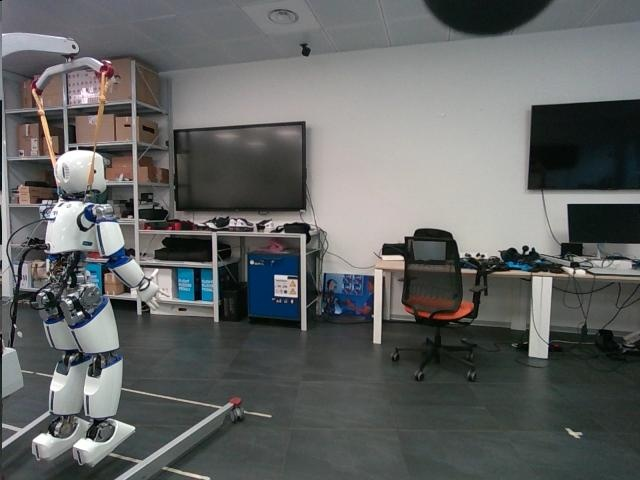

In [390]:
Image.fromarray(image_source)

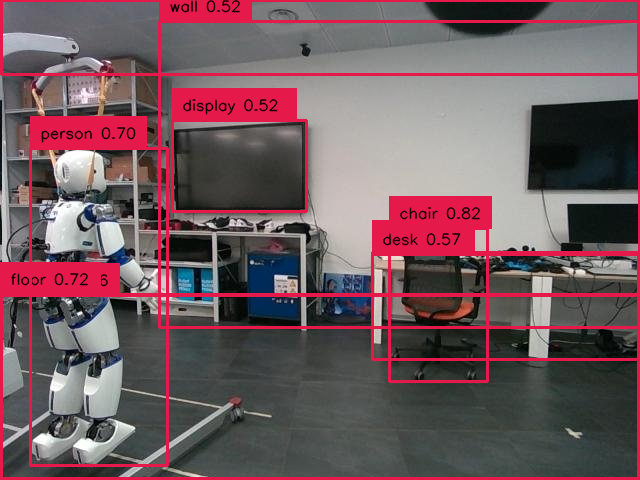

In [380]:
Image.fromarray(annotated_frame)

# Run the segmentation model

In [391]:
import gc
del gsam.groundingdino_model

In [392]:
torch.cuda.empty_cache()
gc.collect()

27623

In [393]:
# set image
gsam.sam_predictor.model.set_image(image_source)

In [394]:
# box: normalized box xywh -> unnormalized xyxy
# H, W, _ = image_source.shape

# boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

# boxes_list = []
# for box in boxes:
#     if box is not None:
#         boxes_list.append(box_ops.box_cxcywh_to_xyxy(box) * torch.Tensor([W, H, W, H]))
# boxes_list = torch.cat(boxes_list)

In [395]:
# transformed_boxes = gsam.sam_predictor.model.transform.apply_boxes_torch(boxes_list, image_source.shape[:2]).to('cpu')


# masks, _, _ = gsam.sam_predictor.model.predict_torch(
#             point_coords = None,
#             point_labels = None,
#             boxes = transformed_boxes,
#             multimask_output = False,
#         )

masks, logits = gsam.sam_predictor.predict_masks_batch(
            image=image_source,
            boxes = boxes,
        )


In [396]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.cpu().reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [397]:

masks = torch.cat(masks, dim=0)


In [398]:
masks.shape

torch.Size([13, 1, 480, 640])

In [399]:
annotated_frame_with_mask = annotated_frame
for mask in masks:
    annotated_frame_with_mask = show_mask(mask[0], annotated_frame_with_mask)

frame_with_mask = image_source
for mask in masks:
    frame_with_mask = show_mask(mask[0], frame_with_mask)

# annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

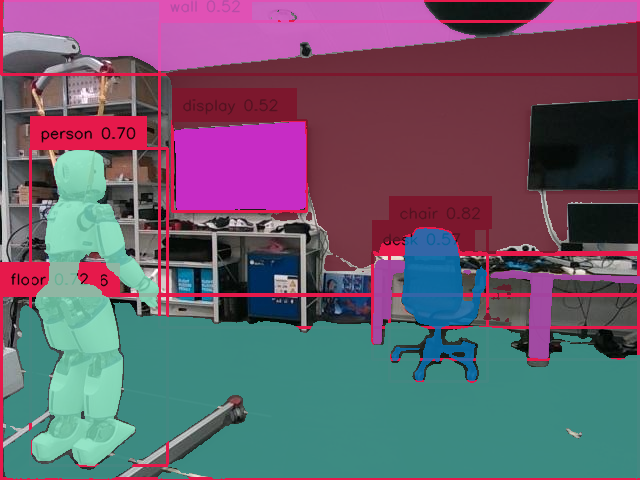

In [400]:
Image.fromarray(annotated_frame_with_mask)

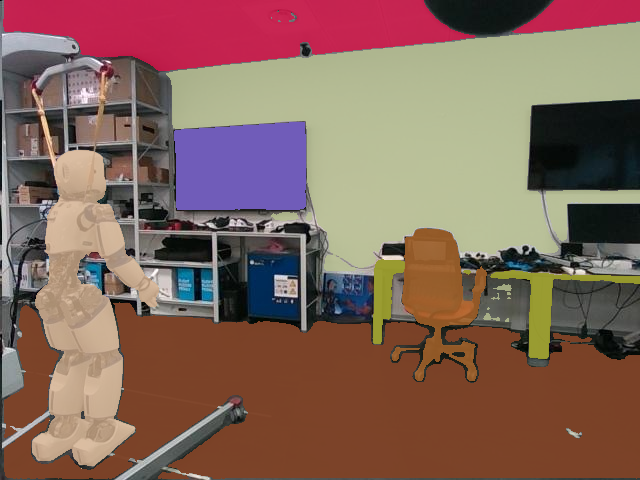

In [401]:
Image.fromarray(frame_with_mask)

# Image Inpainting

In [189]:
image_mask = masks[0][0].cpu().numpy()

In [172]:
image_source_pil = Image.fromarray(image_source)
annotated_frame_pil = Image.fromarray(annotated_frame)
image_mask_pil = Image.fromarray(image_mask)
annotated_frame_with_mask_pil = Image.fromarray(annotated_frame_with_mask)

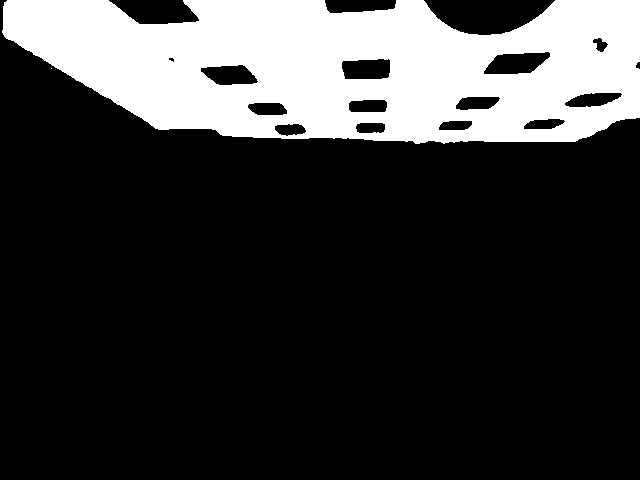

In [115]:
image_mask_pil

In [25]:
# # resize for inpaint
# image_source_for_inpaint = image_source_pil.resize((512, 512))
# image_mask_for_inpaint = image_mask_pil.resize((512, 512))

In [182]:
# prompt = "A sofa, high quality, detailed, cyberpunk, futuristic, with a lot of details, and a lot of colors."
# #image and mask_image should be PIL images.
# #The mask structure is white for inpainting and black for keeping as is
# image_inpainting = pipe(prompt=prompt, image=image_source_for_inpaint, mask_image=image_mask_for_inpaint).images[0]

100%|██████████| 50/50 [00:02<00:00, 17.54it/s]


In [183]:
# image_inpainting = image_inpainting.resize((image_source_pil.size[0], image_source_pil.size[1]))

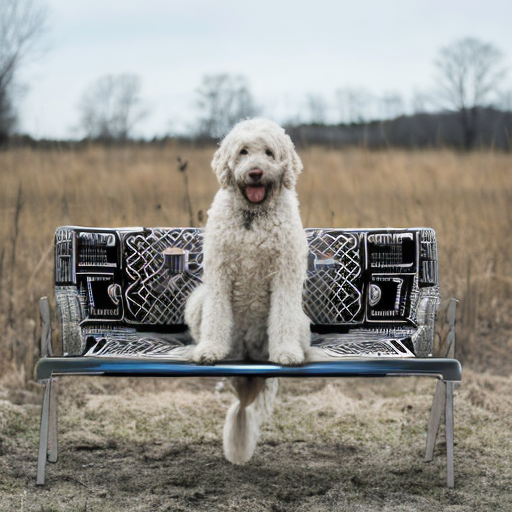

In [184]:
# image_inpainting